<a href="https://colab.research.google.com/github/deiveleal/Comparative_Analysis_Traditional_Clustering_Ensemble_Methods/blob/main/Notebook/%5BVota%C3%A7%C3%A3o_Fred_Jain%5D_Ensemble_Testes_com_Dataset_Globular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.stats import mode
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

###Ensemble

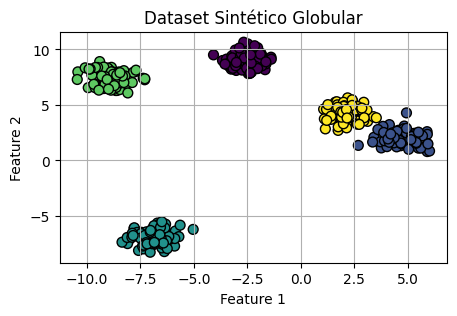

In [ ]:
# Gerando um dataset sintético com 5 grupos bem separados
X, true_labels = make_blobs(n_samples=500, centers=5, cluster_std=0.60, random_state=42)

# Plotando o dataset
plt.figure(figsize=(5, 3))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Dataset Sintético Globular')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

In [ ]:
def generate_base_partitions(X, n_clusters_list, n_init, algorithms):
    """ Gera múltiplas partições base com diferentes algoritmos. """
    base_partitions = []
    for algo in algorithms:
        for k in n_clusters_list:
            for _ in range(n_init):
                if algo == "kmeans":
                    model = KMeans(n_clusters=k, n_init=10, random_state=None)
                elif algo == "agglomerative":
                    model = AgglomerativeClustering(n_clusters=k)
                elif algo == "dbscan":
                    model = DBSCAN(eps=0.5, min_samples=10)
                elif algo == "spectral":
                    model = SpectralClustering(n_clusters=k, n_init=10, random_state=None, affinity='nearest_neighbors')
                labels = model.fit_predict(X)
                base_partitions.append(labels)
    return base_partitions

def create_coassociation_matrix(base_partitions, n_samples):
    """ Cria a matriz de co-associação a partir das partições base. """
    coassociation_matrix = np.zeros((n_samples, n_samples))
    n_partitions = len(base_partitions)

    for labels in base_partitions:
        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels[i] == labels[j]:
                    coassociation_matrix[i, j] += 1
                    if i != j:
                        coassociation_matrix[j, i] += 1

    # Normalizando a matriz de co-associação
    coassociation_matrix /= n_partitions
    return coassociation_matrix

def consensus_clustering(coassociation_matrix, n_clusters):
    """ Aplica clustering baseado em ligação na matriz de co-associação. """
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    consensus_labels = model.fit_predict(1 - coassociation_matrix)
    return consensus_labels

def evaluate_ensemble(X, true_labels, n_clusters_list, n_init, algorithms, n_clusters):
    """ Avalia o clustering ensemble usando ARI e Silhueta. """
    base_partitions = generate_base_partitions(X, n_clusters_list, n_init, algorithms)
    coassociation_matrix = create_coassociation_matrix(base_partitions, X.shape[0])
    consensus_labels = consensus_clustering(coassociation_matrix, n_clusters)
    ari_score = adjusted_rand_score(true_labels, consensus_labels)
    silhouette_avg = silhouette_score(X, consensus_labels)
    return ari_score, silhouette_avg

def analyze_clustering(X, true_labels, n_clusters=5):
    """ Aplica diferentes algoritmos de clustering e calcula ARI e Silhuete. """
    algorithms = {
        'KMeans': KMeans(n_clusters=n_clusters, n_init=10, random_state=None),
        'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters),
        'Spectral': SpectralClustering(n_clusters=n_clusters, n_init=10, random_state=None, affinity='nearest_neighbors'),
     }
    results = {}
    for name, algo in algorithms.items():
        labels = algo.fit_predict(X)
        ari = adjusted_rand_score(true_labels, labels)
        silhouette = silhouette_score(X, labels)
        results[name] = (ari, silhouette)
    return results


In [ ]:
# Definindo os parâmetros para o ensemble
n_clusters_list = [5]  # Número de clusters conhecido
n_init = 10  # Número de inicializações
algorithms = ['kmeans', 'agglomerative', 'spectral']  # Algoritmos
n_clusters = 5  # Número de clusters conhecido

# Avaliando o ensemble de clustering
ari_score, silhouette_avg = evaluate_ensemble(X, true_labels, n_clusters_list, n_init, algorithms, n_clusters)

# Exibindo os resultados
print("Adjusted Rand Index:", ari_score)
print("Silhouette Score:", silhouette_avg)

In [ ]:
# Avaliando os algoritmos de clustering individualmente
results = analyze_clustering(X, true_labels)

# Exibindo os resultados
for method, scores in results.items():
    print(f"{method} - Adjusted Rand Index: {scores[0]:.4f}, Silhouette Score: {scores[1]:.4f}")
